<a href="https://colab.research.google.com/github/gawankarsanket/dswithchirag_assignments/blob/main/Assignment_Transformer_T5_Tuning_for_summerization_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#T5
[
https://machine-learning-made-simple.medium.com/what-are-the-different-types-of-transformers-in-ai-5085275664e8](https://)


There are three broad categories based on their training methodologies

1. Auto -Regressive  (GPT)
2. Auto-Encoding (BERT)
3. equence-to-Sequence (BART/T5)

T5 is encoder-ecoder model ie sequence to sequence.

Sequence-to-Sequence

Sequence-to-sequence models are the OG Transformers.
The approach is pretty straightforward, the input sequence in encoder, forms an embedding process to extract the features  and pass it further to decoder.
These were primarily designed for translation,summerisation tasks, due to their excellence at mapping sequences between languages.


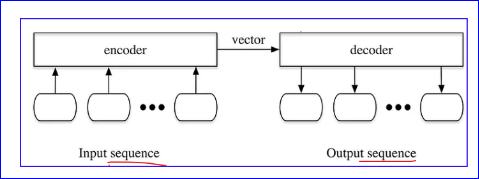




With these architectures, the focus is on taking and mapping sequences to each other. This makes them ideal for translation-related tasks.

# T5 tuned for summerization

making use of pretrained T5 model for summerisation, train it for our input data and get the output with increased accuracy

Some Reference Link : https://learnopencv.com/fine-tuning-t5/#results

Dataset Link : https://www.kaggle.com/datasets/sunnysai12345/news-summary/code

## Install necessary Libraries

In [1]:
!pip install transformers -q  #this gives acess to HungginFace Transoformer based models
!pip install datasets -q    #This enables us to download dataset
!pip install tensorboard -q
!pip install sentencepiece -q    # text tokenization
!pip install accelerate -q  #automates the training of Transformers across different hardware types and also handles multi-GPU training.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 2.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import torch
from datasets import load_dataset
from transformers import T5Tokenizer, T5ForConditionalGeneration, TrainingArguments,Trainer

## Load the dataset

In [3]:
df=pd.read_csv("/content/news_summary.csv",encoding='latin-1') #Encoding picked up trial n error basis.
df.head(2)


,author,date,headlines,read_more,text,ctext
0,Chhavi Tyagi,"03 Aug 2017,Thursday",Daman & Diu revokes mandatory Rakshabandhan in...,http://www.hindustantimes.com/india-news/raksh...,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Daisy Mowke,"03 Aug 2017,Thursday",Malaika slams user who trolled her for 'divorc...,http://www.hindustantimes.com/bollywood/malaik...,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."


# Here we will be interested in column Ctext  which news and text which is summary of that news.
# so we will take these two columns for further training

In [4]:
df=df[['text','ctext']]
df.rename(columns={'text':'summary','ctext':'news'},inplace=True) #Rename for better naming
df.head(2)

,summary,news
0,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."


In [5]:
df.isnull().sum()   #Check for Null values

summary      0
news       118
dtype: int64

In [6]:
df.dropna(inplace=True)   # Drop null values

In [7]:
df.shape

(4396, 2)

#T5 model needs input prompt with instruction  like summerize:abcdcrgxxxxx
# will prefix the instruction in ctext colummn

In [8]:
df['news']='summerize:' + df.loc[:,('news')]   # df.loc[<row range>,<column list>]  We applied on all rows in column 'news'

#df['news']='summerize:'+df['news']   #This is also ok but givee ceavats warning
df.head(2)

,summary,news
0,The Administration of Union Territory Daman an...,summerize:The Daman and Diu administration on ...
1,Malaika Arora slammed an Instagram user who tr...,summerize:From her special numbers to TV?appea...


## Split dataset for train,validation and test

In [9]:
len(df)

4396

In [30]:
xtest=df['news'][3896:]  #last 500 kept for testing
ytest=df['summary'][3896:]

x=df['news'][:3896]   #leaving lasst 500, rest 3896 from begining took for train and validation
y=df['summary'][:3896]

In [11]:
type(x)

pandas.core.series.Series

In [12]:
 #Tokeniser accpets ONLY string or list of strings
 #Hence iterate over each item of series x and y (created above) and form a list
# create_list is fuction

def create_list(series):
  lst=[str(i)for i in series]
  return lst

In [13]:
xlist=create_list(x)
ylist=create_list(y)


In [14]:
type(xlist), len(xlist), type(ylist), len(ylist)

(list, 3896, list, 3896)

In [15]:
#SPLIT FOR TRAIN AND VALIDATION
from sklearn.model_selection import train_test_split

xtrain,xval,ytrain,yval= train_test_split(xlist,ylist, test_size=0.2, random_state=7)

len(xtrain),len(xval),len(ytrain),len(yval)

(3116, 780, 3116, 780)

In [16]:
type(xtrain),type(xval),type(ytrain),type(yval)

(list, list, list, list)

## Tokenization

### While using pretrained model, it’s important to use the associated pretrained tokenizer. This ensures the text is split the same way as the pretraining corpus, and uses the same corresponding tokens-to-index (usually referred to as the vocab) during pretraining.

In [17]:
#from transformers import AutoTokenizer

tokenizer=T5Tokenizer.from_pretrained('google-t5/t5-small')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [18]:
# TOKENIZER FUNCTION
max_len=512
def perform_tokenisation(text):
  tokenized_item=tokenizer(text,return_tensors="pt",max_length=max_len,truncation=True, padding='max_length')
  return tokenized_item


In [19]:
# Tokenize input texts


xtrain_text = perform_tokenisation(xtrain)
ytrain_text = perform_tokenisation(ytrain)

xval_text=perform_tokenisation(xval)
yval_text=perform_tokenisation(yval)


#truncation=True, padding=True,max_length=512, add_special_tokens=True, return_attention_mask=True

## Creating dataset objects to be read by Trainer

In [20]:
# Convert tokenized encodings to dataset objects

from datasets import Dataset

train_dataset = Dataset.from_dict({"input_ids": xtrain_text["input_ids"], "attention_mask": xtrain_text["attention_mask"], "labels": ytrain_text["input_ids"]})
eval_dataset = Dataset.from_dict({"input_ids": xval_text["input_ids"], "attention_mask":xval_text["attention_mask"], "labels": yval_text["input_ids"]})

#NOTE: These dataset object will be given to Trainer. Trainer would need input seq also the output sequencce to measure the loss and trigger backpropogation.

In [21]:
train_dataset,eval_dataset


(Dataset({
     features: ['input_ids', 'attention_mask', 'labels'],
     num_rows: 3116
 }),
 Dataset({
     features: ['input_ids', 'attention_mask', 'labels'],
     num_rows: 780
 }))

## Define Argumaents

This set will be passed in trainer

In [22]:
# picking  up values from one of Kaggle notebook

training_args = TrainingArguments(
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    logging_dir='./logs',
    logging_steps=100,
    save_steps=1000,
    evaluation_strategy="steps",
    output_dir='./results',
    overwrite_output_dir=True,
)


## Initialize model




In [23]:
model= T5ForConditionalGeneration.from_pretrained('t5-small')

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

## Create Trainer

In [24]:
trainer = Trainer(model=model,args=training_args,train_dataset=train_dataset,eval_dataset=eval_dataset)


## Train model


In [25]:
trainer.train()


Step,Training Loss,Validation Loss
100,2.810800,0.388352
200,0.415400,0.350106
300,0.378500,0.334570
400,0.359800,0.328780
500,0.370400,0.322657
600,0.353500,0.320173
700,0.355500,0.317999
800,0.343500,0.316760
900,0.349900,0.315873
1000,0.348000,0.313727


TrainOutput(global_step=2337, training_loss=0.45104999852374317, metrics={'train_runtime': 1440.384, 'train_samples_per_second': 6.49, 'train_steps_per_second': 1.622, 'total_flos': 1265175160160256.0, 'train_loss': 0.45104999852374317, 'epoch': 3.0})

## Evalute model

In [26]:
trainer.evaluate()


{'eval_loss': 0.30901965498924255,
 'eval_runtime': 24.3765,
 'eval_samples_per_second': 31.998,
 'eval_steps_per_second': 8.0,
 'epoch': 3.0}

# PREDICTION  ON TEST DATASET

In [31]:
# we have Xtest and ytest as test dataset
len(xtest),len(ytest)

(500, 500)

In [32]:
#Create list of xtest

xtest_list=create_list(xtest)



In [50]:
#Tokenize xtest_list

xtest_tokenized=perform_tokenisation(xtest_list)

In [51]:
xtest_tokenized

{'input_ids': tensor([[ 1248,  1737,    10,  ...,     0,     0,     0],
        [ 1248,  1737,    10,  ...,     0,     0,     0],
        [ 1248,  1737,    10,  ...,     0,     0,     0],
        ...,
        [ 1248,  1737,    10,  ..., 20676, 12402,     1],
        [ 1248,  1737,    10,  ...,     0,     0,     0],
        [ 1248,  1737,    10,  ...,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [53]:
#dataset object

xtest_dataset = Dataset.from_dict({"input_ids": xtest_tokenized["input_ids"], "attention_mask":xtest_tokenized["attention_mask"]})


In [54]:
xtest_dataset

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 500
})

In [67]:
raw_pred= trainer.predict(xtest_dataset)

ValueError: You have to specify either decoder_input_ids or decoder_inputs_embeds

## PICKLE THE MODEL

In [ ]:
import pickle

file_path = "tunedT5_Summerisation.pkl"

with open(file_path, "wb") as f:
    pickle.dump(model, f)

print("Model pickled successfully!")


Model pickled successfully!
